This notebook is used to debug false positive predictions of a model.
Please run the run.sh first and save the result in the "../results/" directory.

In [ ]:
import torch

import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from utils import split_model, batch_inference, show, visualize_chain_of_concepts, get_conditional_modules, load_data, load_model_data
from torchvision import models
import torch.nn as nn
from math import ceil
from matplotlib import pyplot as plt
from utils import show
import random
from NeurFlow import Framework

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

data_dir = "/mnt/disk1/user/Tue.CM210908/imagenet"
directory = "../results/"
model_name = "resnet50"
label_id = 309
tau = 16
path = directory+ f"store_{model_name}_label{label_id}_tau{tau}.pth"

store = torch.load(path, map_location="cpu", weights_only=False)
FW: Framework = store["FW"]
layers = store["layers"]
del store

print(layers)

from torchvision import models
if model_name == "resnet50":
    model = models.resnet50(pretrained=True).eval()
    all_layers = ["layer4.2", "layer4.1", "layer4.0", "layer3.5", "layer3.4",
                  "layer3.3", "layer3.2", "layer3.1", "layer3.0", "layer2.3",
                  "layer2.2", "layer2.1", "layer2.0", "layer1.2", "layer1.1", "layer1.0"]
    conditional_modules = get_conditional_modules(model_name)
elif model_name == "googlenet":
    model = models.googlenet(pretrained=True).eval()
    all_layers = ["inception5b", "inception5a", "inception4e", "inception4d",
                  "inception4c", "inception4b", "inception4a", "inception3b",
                  "inception3a"]
    conditional_modules = get_conditional_modules(model_name)
elif model_name == "alexnet":
    model = models.alexnet(pretrained=True).eval()
    conditional_modules = {"classifier_0": nn.Flatten(), "classifier": nn.Flatten()}
else:
    raise ValueError("Model not supported")


cuda
['fc', 'layer4.2', 'layer4.1', 'layer4.0', 'layer3.5', 'layer3.4', 'layer3.3', 'layer3.2', 'layer3.1', 'layer3.0', 'layer2.3']


/home/tueminh.cao/miniconda3/envs/neurflow/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tueminh.cao/miniconda3/envs/neurflow/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We load data and find misclassified images.

In [ ]:
all_images, all_labels = load_data(data_dir, [label_id], verbose=True) 

with torch.no_grad():  # Disable gradient computation for inference
    outputs = batch_inference(model, all_images, device=device)
    _, predicted_labels = torch.max(outputs, 1)

predicted_labels = predicted_labels.detach().cpu()
mask = torch.isin(predicted_labels, torch.tensor(label_id))
class_images = all_images[mask]
class_labels = all_labels[mask]

misclassified_mask = torch.isin(class_labels, torch.tensor([label_id]))
misclassified_indices = torch.where(misclassified_mask, False, True)
misclassified_images = class_images[misclassified_indices]
misclassified_labels = class_labels[misclassified_indices]

true_class_mask = torch.isin(all_labels, torch.tensor(label_id))
false_negative = true_class_mask & ~ mask
false_negative_images = all_images[false_negative]
false_negative_predicted_label = predicted_labels[false_negative]

print("All images shape: ", all_images.shape)
print("Class images shape: ", class_images.shape)
print("Misclassified images shape:", misclassified_images.shape)
print("False negative shape:", false_negative_images.shape)

Loading data...
All images shape:  torch.Size([1001, 3, 224, 224])
Class images shape:  torch.Size([45, 3, 224, 224])
Misclassified images shape: torch.Size([5, 3, 224, 224])
False negative shape: torch.Size([10, 3, 224, 224])


We first visualize the image we are working with.

True label: 301


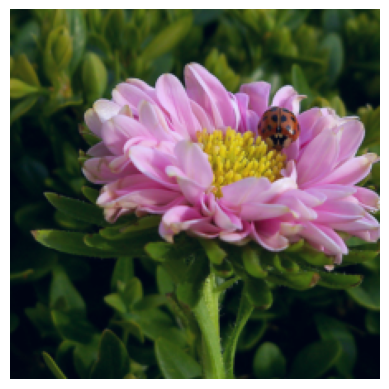

In [3]:
img_debug = 0

print("True label:", misclassified_labels[img_debug].item())
show(misclassified_images[img_debug])

# print("Predicted label:", false_negative_predicted_label[img_debug].item())
# show(false_negative_images[img_debug])

# print("True label:", class_labels[img_debug].item())
# show(class_images[img_debug])

We find what concepts at the debug_layer activate the most on the image.

Cluster label: 0


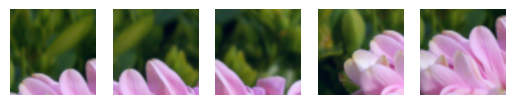

Feature map: 1185
Label: 3


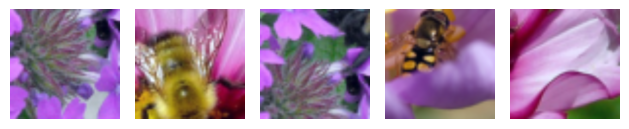

Cluster label: 1


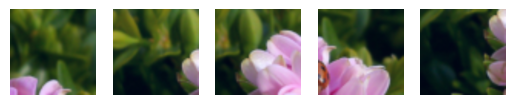

Feature map: 617
Label: 1


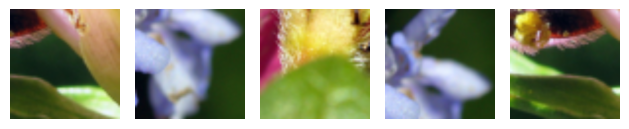

Max barier scores: {0: 0.8640465615093343, 1: 0.7410575450937346, 2: 0.1852527220255178}


In [4]:
debug_layer = 9                        # layer to debug

img = misclassified_images[img_debug]
# img = false_negative_images[img_debug]
# img = class_images[img_debug]

netA, _ = split_model(
    model, 
    layers[-debug_layer-1], 
    include_split_layer_in_first_part=True, 
    conditional_modules=conditional_modules
)

FW.debug_img(
    img,                                
    debug_layer,                        
    netA,                               
    n_cluster=3,                        # number of clusters
    threshold=0.6,                      # visualize threshold
    specific_concept=None,              # specific concept to visualize
    granularities = [0.25, 0.5, 1],     # granularities to visualize
    num_top_vecs=3,                     # number of top vectors for each concept
    num_show_per_concept=1              # number of examples to show for each concept
)

We can trace back what concepts at lower layer have strong impacts on the concept of upper layer.
The dictionary have the structure: {lower_layer_concept_id: score}.

Feature map: 1185
Label: 3


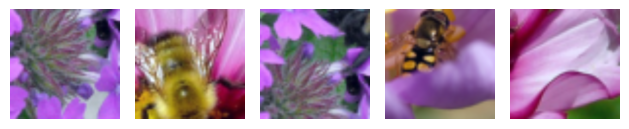

=========layer:8===========
Top concepts of 0 are: {0: 2.149894973683877, 3: 1.1582589577369162}
------Layer: 8 cluster_label: 0 ------
Feature map: 974
Label: 0


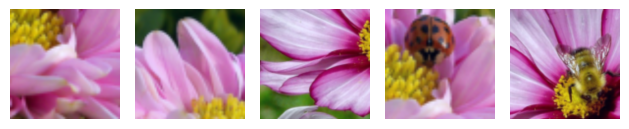

------Layer: 8 cluster_label: 3 ------
Feature map: 202
Label: 0


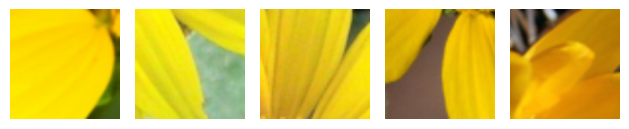

=========layer:7===========
Top concepts of 0 are: {6: 0.007711121841037332, 3: 0.0037820611537388174}
Top concepts of 3 are: {7: 3.191229994244458, 1: 0.003807450717778953}
------Layer: 7 cluster_label: 1 ------
Feature map: 1960
Label: 0


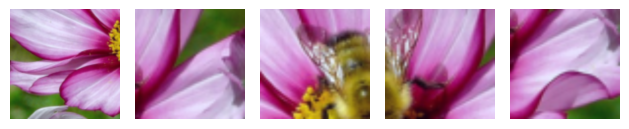

------Layer: 7 cluster_label: 3 ------
Feature map: 736
Label: 1


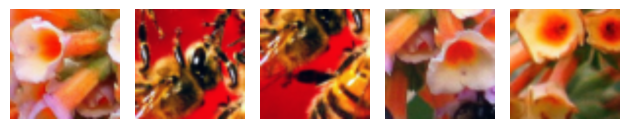

------Layer: 7 cluster_label: 6 ------
Feature map: 425
Label: 0


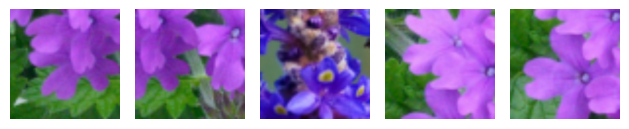

------Layer: 7 cluster_label: 7 ------
Feature map: 1859
Label: 0


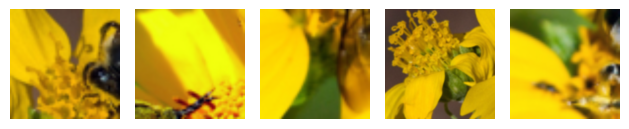

In [7]:
list_num_cluster = [10, 5, 3]   # number of cluster per layer
concept_id = 0                  # id of concept to visualize
end = 9                         # layer of the concept 
start = 7                       # trace back to start layer
num_top_concepts= 2             # number of top concepts at previous layer
num_top_vecs = 10               # number of representation vectors for each concept
specify_cluster = True          # whether to specify the number of cluster - if false then this function will self-determine

visualize_chain_of_concepts(
    FW, 
    concept_id, 
    start, 
    end, 
    num_top_concepts, 
    list_num_cluster,
    specify_cluster,
    num_top_vecs = num_top_vecs,
)

Now we want to test our understanding of the model: whether the prediction really based on the concepts we found.
We want to mask the neurons related to the concepts. 

In [20]:
'''
Define:
- cluster_layer: the layer to cluster
- num_cluster: the number of clusters
- cluster_to_mask: the labels of the clusters
'''
cluster_layer = 9
num_cluster = 3
cluster_to_mask = [0, 1]

dict_labels, _ = FW.cluster_concept_vectors(cluster_layer, num_cluster, num_top_vecs=None, max_n_clusters=100)
indices = set()
for fm, temp_dict in dict_labels.items():
    for label, temp_cluster_label in temp_dict.items():
        if temp_cluster_label in cluster_to_mask:
            indices.add(fm)
indices = list(indices)
print("Cluster to mask:", cluster_to_mask)
print("The cluster to mask contains these indices:", indices)

netA, netB = split_model(
    model, 
    layers[-cluster_layer-1], 
    include_split_layer_in_first_part=True, 
    conditional_modules=conditional_modules
)
netA = netA.to(device)
netB = netB.to(device)

def masked_probing(data, indices, net, device = "cuda", batch_size = 128, reverse = False):
    data = data.to("cpu")
    if reverse:
        reverse_indices = [i for i in range(data.shape[1]) if i not in indices]
        data[:, reverse_indices] = 0
    else:
        data[:, indices] = 0    
    return batch_inference(net, data, batch_size=batch_size, device = device)

def percentage_of_predictions(out):
    # percentage of predictions
    percentage = torch.nn.functional.softmax(out, dim=1)
    return percentage

Cluster to mask: [0, 1]
The cluster to mask contains these indices: [1824, 1185, 898, 1797, 617, 974, 911, 432, 884, 1332, 895]


Now we see how the predictions change.

In [ ]:
topk = 5  # the top-k predictions

intermediate = netA(
    misclassified_images[img_debug].unsqueeze(0).to(device)
)
# generate random indices
indices_random = random.sample(range(0, intermediate.shape[1]), len(indices))

out = masked_probing(intermediate, indices, netB, device = device)

_, predicted_labels = torch.topk(out[0], topk)
test_label = label_id
original_out = model(misclassified_images[img_debug].unsqueeze(0).to(device))

print("Critical neuron masking:")
print(f"Top {topk} predictions:", predicted_labels)
print(f"Top {topk} prediction probabilities:", percentage_of_predictions(out)[0, predicted_labels])
print("Logit difference:",  (out[0, test_label]-original_out[0, test_label]).detach().cpu().item())

Critical neuron masking:
Top 5 predictions: tensor([985, 309, 984, 301, 937])
Top 5 prediction probabilities: tensor([0.2772, 0.1858, 0.1802, 0.0479, 0.0346])
Logit difference: -5.06488037109375


We want to test: whether the neuron group is related to the concept we visualize.

Cluster to mask: [0]
The cluster to mask contains these indices: [1824, 1185, 898, 1797, 974, 911, 432, 1332, 895]


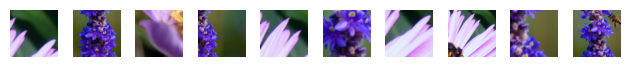

In [25]:
input_data = FW.concept_data   # NOTE: uncomment this to test on augmentation data
# input_data = class_images    # NOTE: uncomment this to test on validation data

cluster_to_mask = [0]    # cluster to mask, should be a list of ONE interger

'''
We will visualize the top 10 images that have the most decrease in the logit of the target class after masking the cluster
'''

dict_labels, _ = FW.cluster_concept_vectors(cluster_layer, num_cluster, num_top_vecs=None, max_n_clusters=100)
indices = set()
for fm, temp_dict in dict_labels.items():
    for label, temp_cluster_label in temp_dict.items():
        if temp_cluster_label in cluster_to_mask:
            indices.add(fm)
indices = list(indices)
print("Cluster to mask:", cluster_to_mask)
print("The cluster to mask contains these indices:", indices)

netA, netB = split_model(
    model, 
    layers[-cluster_layer-1], 
    include_split_layer_in_first_part=True, 
    conditional_modules=conditional_modules
)
netA = netA.to(device)
netB = netB.to(device)

intermediate = batch_inference(netA, input_data, device=device)
out = masked_probing(intermediate, indices, netB, device = device)
_, predicted_labels = torch.topk(out, 1)
original_out = batch_inference(model, input_data, device=device)
diff = original_out[:, label_id] - out[:, label_id]
top_decrease = torch.topk(diff, 10)[1].detach().cpu()
top_decrease_imgs = input_data[top_decrease]

for i, image in enumerate(top_decrease_imgs):
    plt.subplot(1, len(top_decrease_imgs), i + 1)
    show(image)
plt.tight_layout()
plt.show()